In [1]:
# Source: 
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with
# %20Neural%20Networks.ipynb

In [1]:
import os
from IPython.display import Image

pth = os.getcwd() # where we started jupyter-notebook
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 1 - Sequence to Sequence Learning with Neural Networks

In this series we'll be building a machine learning model to go from once sequence to another, using PyTorch and TorchText. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization.

In this first notebook, we'll start simple to understand the general concepts by implementing the model from the Sequence to [Sequence Learning with Neural Networks paper](https://arxiv.org/pdf/1409.3215.pdf).


## Introduction

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector. 
We'll refer to this single vector as a context vector. The context vector is an abstract representation of the entire input sentence. 
This context vector will be decoded by a second RNN which learns to output the target (output) sentence by generating it one word at a time.


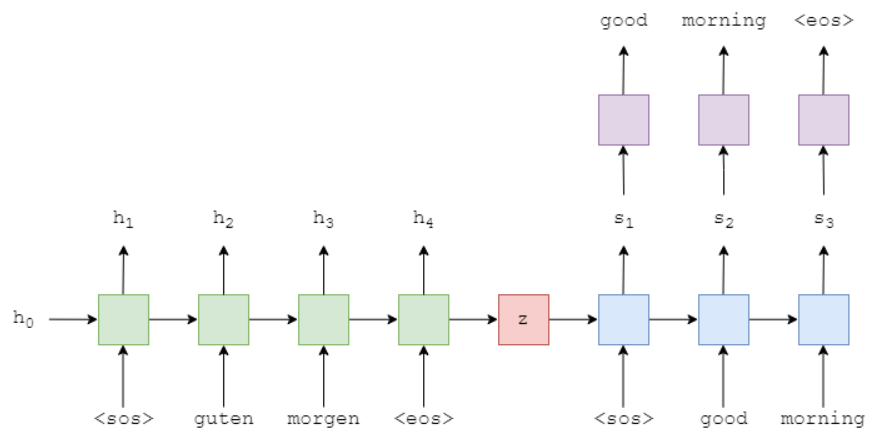

In [2]:
Image(filename= pth + "/images/rnn_translation.png")

The image above shows an example translation.

### RNN Overview: 

The general RNN model takes an input $x_t$ and a hidden state $h_{t-1}$ from the previous time step, and the RNN uses these to output a new hidden state $h_t$. 
Hidden state $h_t$ is a vector representation of the sentence so far (memory). The RNN can be represented as a function of both $x_t$ and $ h_{t-1} $:

**NOTE: RNN could mean any recurrent architecture, such as an LSTM (Long Short-Term Memory) or a GRU (Gated Recurrent Unit)**

#### [RNN's Forward Pass Logic](https://hyp.is/2A7dNArKEeqrZPMWahsTYQ/pytorch.org/docs/stable/nn.html): 
$$ h_t = RNN(x_t, h_{t-1})  $$
$$     = tanh(W_{ih} * x_t + W_{hh} * h_{t-1} + b_{hh}) $$

#### RNN's Update Rule: 
$$
c_t = tanh(W_h * c_{t-1} + W_i * x_t)
$$

#### Variable Meanings: 

$ x_t = $ input tensor at time $t$

$ h_t = $ hidden state tensor at time $t$

$ h_{t-1} = $ hidden state of the previous layr at time $t - 1$ or the initial hidden state at time $0$. 

[The weight tensors are:](https://hyp.is/e_hoDA0AEeqmEr_FYxTetw/pytorch.org/docs/stable/nn.html)

$W_{ih} =$ the learnable input-to-hidden weight tensor **for the layers**, where each row corresponds to the input-hidden weights for a particular layer. 

If layer = 0, $W_{ih}$ has shape 
(4 * `hiddenLayerSize`, `inputLayerSize`) 

else it has shape 
(4 * `hiddenLayerSize`, `numDirections` * `hiddenLayerSize`)} 

$W_{hh} =$ the learnable hidden-to-hidden weight tensor **for the layers**, where each row corresponds to the hidden-hidden weights for a particular layer. 
This tensor has shape (`hiddenLayerSize`, `hiddenLayerSize`) 


[The bias tensors are:](https://hyp.is/wL3u8g0BEeqCvecy5984hQ/pytorch.org/docs/stable/nn.html)
$$
b_{ih} = \text{the learnable input-to-hidden bias of the layers. Is a 1-dim tensor with shape } (`hiddenLayerSize`) \\
b_{hh} = \text{the learnable hidden-to-hidden bias of the layers. Is a 1-dim tensor with shape } (`hiddenLayerSize`) \\
$$




### Encoder Overview: 

The input sentence "guten morgen" is input into the encoder (green boxes) one word at a time. 
We also append a *start of sequence* `<sos>` to the start of the sentence and *end of sequence* `<eos>` token to the end of the sentence. 

At each time-step, the input to the encoder RNN is both the current word 

##### Variable Interpretations for Encoder: 

[The inputs are:](https://hyp.is/Wj40JArNEeqG-0uE-Y9kqg/pytorch.org/docs/stable/nn.html)

\begin{array}{ll}
X = \{x_1, x_2, ..., x_T\} \\
x_1 = \text{<sos>} \\
x_2 = \text{guten} \\
x_3 = \text{morgen} \\
x_4 = \text{<eos>} \\
\end{array}

The hidden states are: 

\begin{array}{ll}
\href{https://hyp.is/h9bs-Az_EeqOS5vSrKnHmA/pytorch.org/docs/stable/nn.html}{h_0} = \text{initial hidden state, usually initialized to zeros or a learned parameter.} \\
h_1 = RNN(x_1, h_0) = \text{the hidden state after applying RNN on first input } x_1 \text{and previous hidden state}, h_0 \\
h_2 = RNN(x_2, h_1) = \text{the hidden state after applying RNN on second input } x_2 \text{and previous hidden state}, h_1 \\
h_3 = RNN(x_3, h_2) = \text{the hidden state after applying RNN on third input } x_3 \text{and previous hidden state}, h_2 \\
h_4 = RNN(x_4, h_3) = \text{the hidden state after applying RNN on fourth input } x_4 \text{and previous hidden state}, h_3 \\
\end{array}


Once the final word, $x_T$, has been passed into the RNN, we use the final hidden state, $h_T$, as the context vector (we will call this resulting context vector $z$, so we let $z := h_T$). This context vector now represents the entire source sentence.


### Decoder Overview: 

Now we have our context vector, $z$, we can start decoding it to get the target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the `DecoderRNN` (blue) is the current word, $y_t$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$. This says the **initial decoder hidden state is the final encoder hidden state.** Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(y_t, s_{t-1})$$

#### Variable Meanings: 

$$
s_t = \text{hidden state of decoder} \\
s_{t-1} = \text{hidden state of decoder from previous time step} \\
s_0 = h_t =: z = \text{initial decoder hidden state, or final encoder hidden state}
y_t = \text{current word input to the decoder} \\

Inside the decoder, we need to go from the hidden state $s_t$ to an actual word, therefore at each time-step we use the hidden state $s_t$ to predict (by passing it through a `Linear` layer $f()$, shown in purple) the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t-1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called [*teacher forcing*](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 


### Training Overview: 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our `loss`. We then use this `loss` to update all of the parameters in our model.



## Preparing Data

We'll be coding up the models in PyTorch and using TorchText to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

## Preparing the Data

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)

# note about reproducibility in CUDA: 
# https://hyp.is/dOiOAAuzEeqcu2OxIZfR4w/pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True 

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word.

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [5]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In the [paper](https://arxiv.org/pdf/1409.3215.pdf) we are implementing, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier".

In [6]:
# Creating the tokenizer functions
# NOTE: reversing due to optimization ease

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    and reverses it
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)][::-1]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)


In [7]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,  
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). 
This is a dataset with ~30,000 parallel English, German and French 
sentences, each with ~12 words per sentence.

In [8]:
# `exts` : specifies which languages to use as the source and target
# (source goes first) 
# `fields`: specifies which field to use for the source and target.

# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = \
    Multi30k.splits(exts = ('.de', '.en'),
                    fields = (SRC, TRG))

In [9]:
# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages. 

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works (?).

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1). 

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [10]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [11]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    device = device)

In [14]:
trainIterator

## Building the Seq2Seq Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.


### Encoder

We will use a 2-layer LSTM for the encoder (the paper uses 4-layer LSTM)
For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. 

Let's represent each layer with a superscript: 

The hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

LSTMs are a type of RNN which instead of just taking in a hidden state $h_{t-1}$ and returning a new hidden state $h_t$ per time-step, also take in and return a *cell state* (a hidden internal state), $c_t$, per time-step.

$$
h_t = \text{RNN}(x_t, h_{t-1}) \\
(h_t, c_t) = \text{LSTM}(x_t, (h_{t-1}, c_{t-1})) \\
h_0^l = \text{tensor of zeros} \\
c_0^l = \text{tensor of zeros} \\
$$

-> [About tensor shapes of $h_0$ and $c_0$](https://hyp.is/Zhr-Kg0wEeqln6cdLJLR0A/pytorch.org/docs/stable/nn.html)

NOTE: Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.

So our encoder looks something like this: 

![](assets/seq2seq2.png)

We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:
- `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
- `emb_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `emb_dim` dimensions. 
- `hid_dim` is the dimensionality of the hidden and cell states.
- `n_layers` is the number of layers in the RNN.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

We aren't going to discuss the embedding layer in these tutorials. All you need to know is that there is a step before the words - technically, the indexes of the words - are passed into the RNN, where the words are transformed into vectors. If you would like to know about word embeddings, I'd recommend these articles [1](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/), [2](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html), [3](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), [4](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/). 

The embedding layer is created using `nn.Embedding`, the LSTM with `nn.LSTM` and a dropout layer with `nn.Dropout`. Check the PyTorch [documentation](https://pytorch.org/docs/stable/nn.html) for more about these.

One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence for us! You may notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros. 

The RNN returns: `outputs` (the top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`. 

The sizes of each of the tensors is left as comments in the code. In this implementation `n_directions` will always be 1, however note that bidirectional RNNs (covered in tutorial 3) will have `n_directions` as 2.

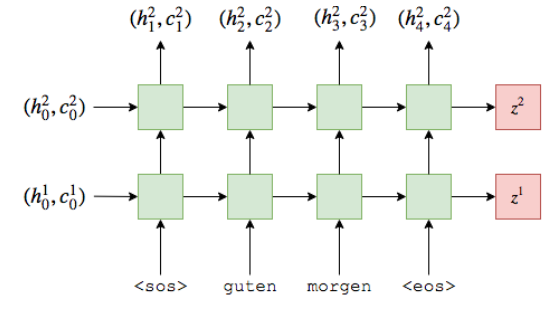

In [18]:
Image(filename = pth + '/images/twolayerlstm.png')


We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. 

The EncoderRNN takes the following arguments:
- `inputDim` = the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
- `embedDim` = the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `embedDim` dimensions.
- `hiddenDim` = the dimensionality of the hidden and cell states (which are tensors).
- `numLayers` = the number of layers in the RNN.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

##### Embedding Layer (brief description): 
This is a step where the words - technically, the indexes of the words - are passed into the RNN, where the words are transformed into vectors. 
- The embedding layer is created using [`nn.Embedding`](https://hyp.is/cv2pSAeqEeqIRHv7JAjgtA/pytorch.org/docs/stable/nn.html)
- The LSTM is created using [`nn.LSTM`](https://hyp.is/R5jTMACPEeqEBPshU7EI4A/pytorch.org/docs/stable/nn.html) 
- The dropout layer is created with [`nn.Dropout`](https://hyp.is/qrKgZg0-EeqHWhNj0dgBjw/pytorch.org/docs/stable/nn.html). 
	- One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence for us! You may notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros. 

The RNN returns: `outputs` (the top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`.

The sizes of each of the tensors is left as comments in the code. In this implementation `n_directions` will always be 1, however note that bidirectional RNNs (covered in tutorial 3) will have `n_directions` as 2.

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, inputDim, embedDim, hiddenDim, numLayers, dropout):
        super().__init__()
        
        self.hiddenDim = hiddenDim
        self.numLayers = numLayers
        
        self.embedding = nn.Embedding(num_embeddings=inputDim, 
                                      embedding_dim=embedDim)
        
        self.rnn = nn.LSTM(input_size=embedDim, 
                           hidden_size=hiddenDim,
                           num_layers=numLayers,
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, src):
        """
        
        :param src: tensor of size (source sentence length, batchsize) (???)
        :return: 
        """
        
        srcEmbedding = self.dropout(self.embedding(src))
        # size is (src sentence len, batch size, embed dim)
        
        outputs, (hidden, cell) = self.rnn(srcEmbedding)

        # EXPLANATION OF LSTM outputs: 
        # https://hyp.is/3_DFrAx5EeqqUF__1DKA2g/pytorch.org/docs/stable/nn.html
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #outputs are always from the top hidden layer
        
        return hidden, cell 